In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir="/content/drive/MyDrive/TESS Toronto emotional speech set data"

In [5]:
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)

    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)

    fft = np.fft.fft(y)
    fft_mean = np.mean(np.abs(fft))

    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = np.mean(mfccs, axis=1)

    spectrogram = librosa.amplitude_to_db(librosa.stft(y))
    spectrogram_mean = np.mean(spectrogram, axis=1)

    # Concatenate features
    features = np.concatenate((chroma_stft_mean, [fft_mean], mfccs_mean, spectrogram_mean))

    return  chroma_stft,fft_mean,mfccs_mean,spectrogram_mean

In [6]:
data =[]

In [7]:
for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        # Loop through each audio file in the class directory
        for file_name in os.listdir(class_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_path, file_name)
                chroma_stft,fft_mean,mfccs_mean,spectrogram_mean = extract_features(file_path)
                # Combine the file name, class, and features into one row
                row = [file_name, class_dir, chroma_stft,fft_mean,mfccs_mean,spectrogram_mean]
                data.append(row)

<ipython-input-5-d9b3f246c7a3>:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(y))


In [8]:
columns = ['file_name', 'class','chroma_stft_mean', 'fft_mean', 'mfccs_mean', 'spectrogram_mean']
df = pd.DataFrame(data, columns=columns)

In [9]:
for col in ['mfccs_mean', 'chroma_stft_mean', 'spectrogram_mean']:
    df[col] = df[col].apply(lambda x: np.array(x).flatten())

In [10]:
max_length = max(len(arr) for arr in df['chroma_stft_mean'])

In [11]:
df_chroma= pd.concat([df["class"],pd.DataFrame(df['chroma_stft_mean'].tolist(), columns=[f'chroma_{i}' for i in range(max_length)])], axis=1)

In [12]:
df_chroma.head()

,class,chroma_0,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,...,chroma_1538,chroma_1539,chroma_1540,chroma_1541,chroma_1542,chroma_1543,chroma_1544,chroma_1545,chroma_1546,chroma_1547
0,neutral,0.708372,0.639090,0.580643,0.842932,0.958821,0.966180,0.472478,0.319310,0.672414,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,neutral,0.705268,0.698773,0.876057,1.000000,0.689523,0.622932,0.670706,0.711864,0.602917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,neutral,0.642918,0.800327,0.807105,0.622455,0.437857,0.658408,0.875171,0.996516,0.892908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,neutral,0.982967,0.940217,0.469341,0.598493,0.401380,0.327679,0.278528,0.470382,0.656918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,neutral,0.589742,0.409054,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_chroma.fillna(0, inplace=True)

In [14]:
df['class'] = df['class'].replace({'neutral':0, 'disgust':1,'Sad':2,'Pleasant_surprise':3, 'angry':4, 'Fear':5,
       'happy':6})


In [15]:
y = df['class']

In [16]:
X = df_chroma.drop(columns=['class'])

In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.svm import SVC

In [20]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [21]:
classifiers={
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'GaussianNB':GaussianNB(),
    'LogisticRegression':LogisticRegression(),
    'SVM-sigmoid':SVC(kernel='sigmoid'),
    'SVM-rbf':SVC(kernel='rbf'),
    'SVM-linear':SVC(kernel='linear'),
     'LGBMClassifier':LGBMClassifier(),
     'XGBClassifier':XGBClassifier()
}

In [22]:
from matplotlib import pyplot as plt

Training and Evaluating RandomForestClassifier
RandomForestClassifierAccuracy: 0.8589285714285714
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        76
           1       0.86      0.89      0.87        89
           2       0.94      0.97      0.96        77
           3       0.69      0.67      0.68        86
           4       0.95      0.75      0.84        76
           5       0.85      0.93      0.89        83
           6       0.83      0.82      0.83        73

    accuracy                           0.86       560
   macro avg       0.86      0.86      0.86       560
weighted avg       0.86      0.86      0.86       560



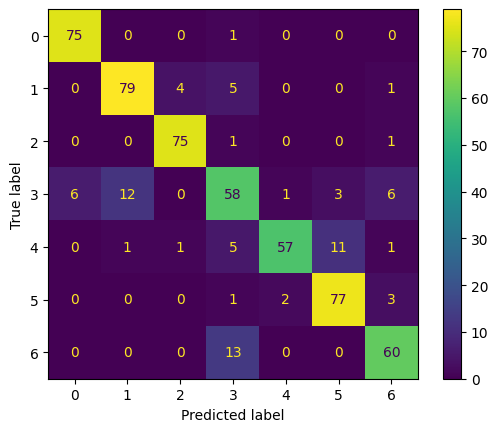

Training and Evaluating GradientBoostingClassifier
GradientBoostingClassifierAccuracy: 0.8857142857142857
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        76
           1       0.90      0.90      0.90        89
           2       0.95      0.96      0.95        77
           3       0.80      0.83      0.81        86
           4       0.85      0.83      0.84        76
           5       0.87      0.92      0.89        83
           6       0.89      0.81      0.85        73

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.89      0.89      0.89       560



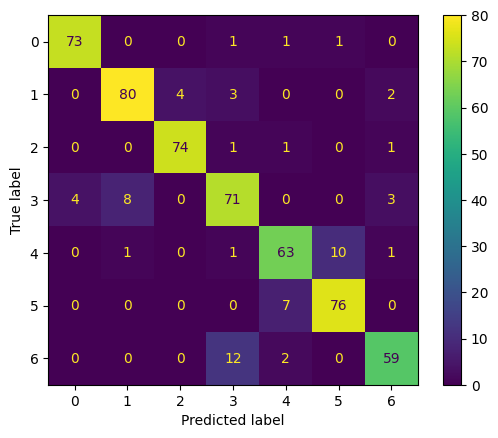

Training and Evaluating GaussianNB
GaussianNBAccuracy: 0.32321428571428573
              precision    recall  f1-score   support

           0       0.55      0.24      0.33        76
           1       0.63      0.52      0.57        89
           2       0.00      0.00      0.00        77
           3       0.12      0.09      0.10        86
           4       0.07      0.01      0.02        76
           5       0.31      0.99      0.47        83
           6       0.25      0.36      0.30        73

    accuracy                           0.32       560
   macro avg       0.27      0.31      0.26       560
weighted avg       0.28      0.32      0.26       560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


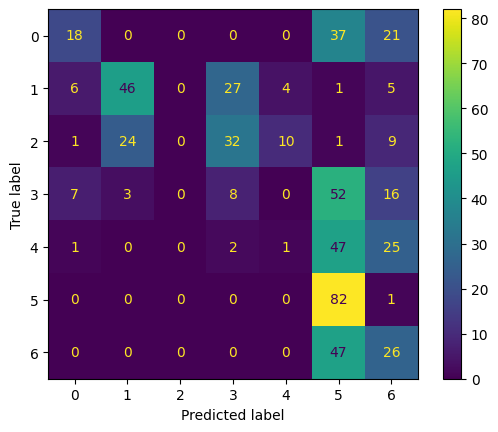

Training and Evaluating LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionAccuracy: 0.8053571428571429
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        76
           1       0.86      0.76      0.81        89
           2       0.83      0.96      0.89        77
           3       0.68      0.55      0.61        86
           4       0.78      0.79      0.78        76
           5       0.88      0.83      0.86        83
           6       0.71      0.82      0.76        73

    accuracy                           0.81       560
   macro avg       0.80      0.81      0.80       560
weighted avg       0.80      0.81      0.80       560



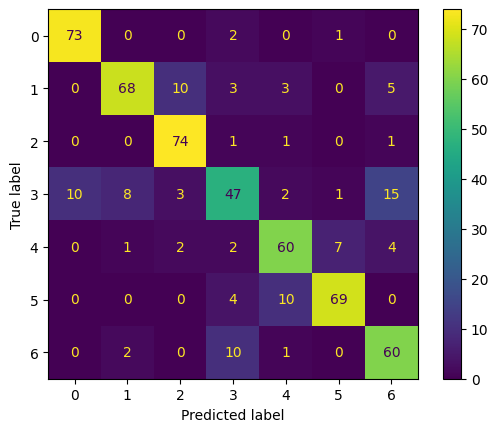

Training and Evaluating SVM-sigmoid
SVM-sigmoidAccuracy: 0.7982142857142858
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        76
           1       0.85      0.75      0.80        89
           2       0.75      0.87      0.81        77
           3       0.64      0.65      0.65        86
           4       0.84      0.74      0.78        76
           5       0.85      0.89      0.87        83
           6       0.80      0.78      0.79        73

    accuracy                           0.80       560
   macro avg       0.80      0.80      0.80       560
weighted avg       0.80      0.80      0.80       560



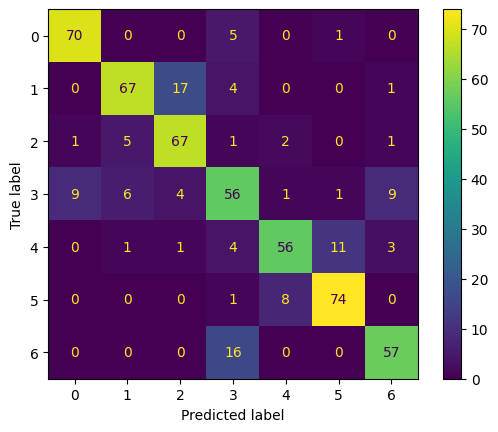

Training and Evaluating SVM-rbf
SVM-rbfAccuracy: 0.8839285714285714
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        76
           1       0.90      0.91      0.91        89
           2       0.94      0.97      0.96        77
           3       0.75      0.79      0.77        86
           4       0.88      0.83      0.85        76
           5       0.87      0.90      0.89        83
           6       0.88      0.81      0.84        73

    accuracy                           0.88       560
   macro avg       0.89      0.88      0.89       560
weighted avg       0.89      0.88      0.88       560



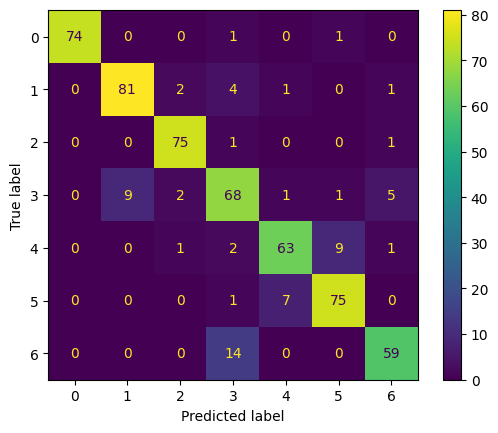

Training and Evaluating SVM-linear
SVM-linearAccuracy: 0.8464285714285714
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        76
           1       0.88      0.85      0.87        89
           2       0.88      0.96      0.92        77
           3       0.73      0.67      0.70        86
           4       0.80      0.80      0.80        76
           5       0.91      0.82      0.86        83
           6       0.80      0.86      0.83        73

    accuracy                           0.85       560
   macro avg       0.85      0.85      0.85       560
weighted avg       0.85      0.85      0.84       560



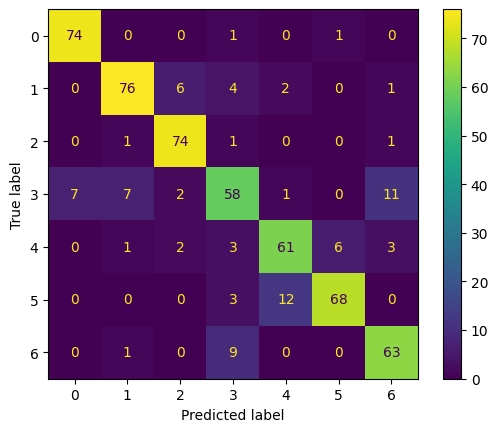

Training and Evaluating LGBMClassifier
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318976
[LightGBM] [Info] Number of data points in the train set: 2240, number of used features: 1440
[LightGBM] [Info] Start training from score -1.933488
[LightGBM] [Info] Start training from score -1.974438
[LightGBM] [Info] Start training from score -1.936579
[LightGBM] [Info] Start training from score -1.964838
[LightGBM] [Info] Start training from score -1.933488
[LightGBM] [Info] Start training from score -1.955329
[LightGBM] [Info] Start training from score -1.924271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

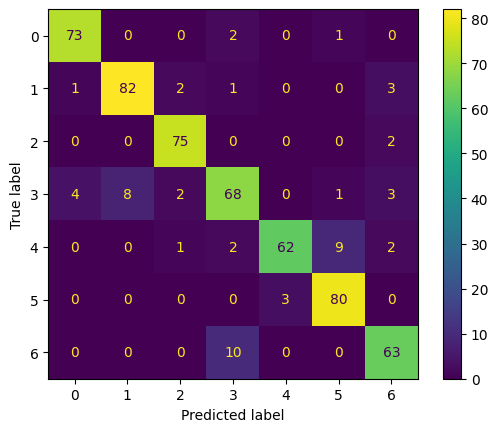

Training and Evaluating XGBClassifier
XGBClassifierAccuracy: 0.8892857142857142
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        76
           1       0.90      0.90      0.90        89
           2       0.94      0.97      0.96        77
           3       0.82      0.79      0.80        86
           4       0.90      0.84      0.87        76
           5       0.88      0.94      0.91        83
           6       0.86      0.81      0.83        73

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.89      0.89      0.89       560



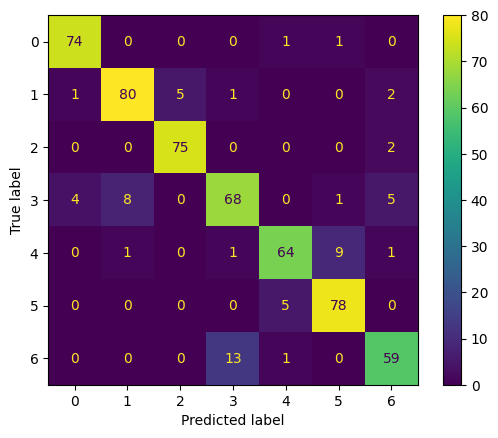

In [23]:
for clf_name,clf in classifiers.items():
  print(f"Training and Evaluating {clf_name}")
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  print(f"{clf_name}Accuracy: {accuracy_score(y_test,y_pred)}")
  print(classification_report(y_test,y_pred))
  cm=confusion_matrix(y_test,y_pred)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
  disp.plot()
  plt.show()